# Esercizio 7: Lennard Jones - Monte Carlo

Si esegue una simulazione Monte Carlo per un modello Lennard-Jones. Tramite l'algoritmo di Metropolis si campiona la distribuzione di Boltzmann (ensemble canonico). 

Si osserva dall'andamento delle osservabili che il sistema raggiunge l'equilibrio dopo circa __200 step MC__

Il passo del Metropolis $\delta$ è regolato in modo da avere accettazione circa 50%. Questo si ha per:
- gas: $\delta = 1$
- liquido: $\delta = 0.2$
- solido: $\delta = 0.11$

#### Struttura
L'esercizio è diviso in due parti:
- Correlazioni e data blocking
- Simulazione del gas Argon

## Correlazioni e data blocking

### Autocorrelazione
Studiamo l'autocorrelazione nelle misure di energia e pressione per individuare la taglia ottimale dei blocchi. Il blocco deve essere sufficientemente grande da fare in modo che la correlazione tra blocchi adiacenti sia solo superficiale

In [1]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import math
import scipy
from scipy import log, exp, sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf

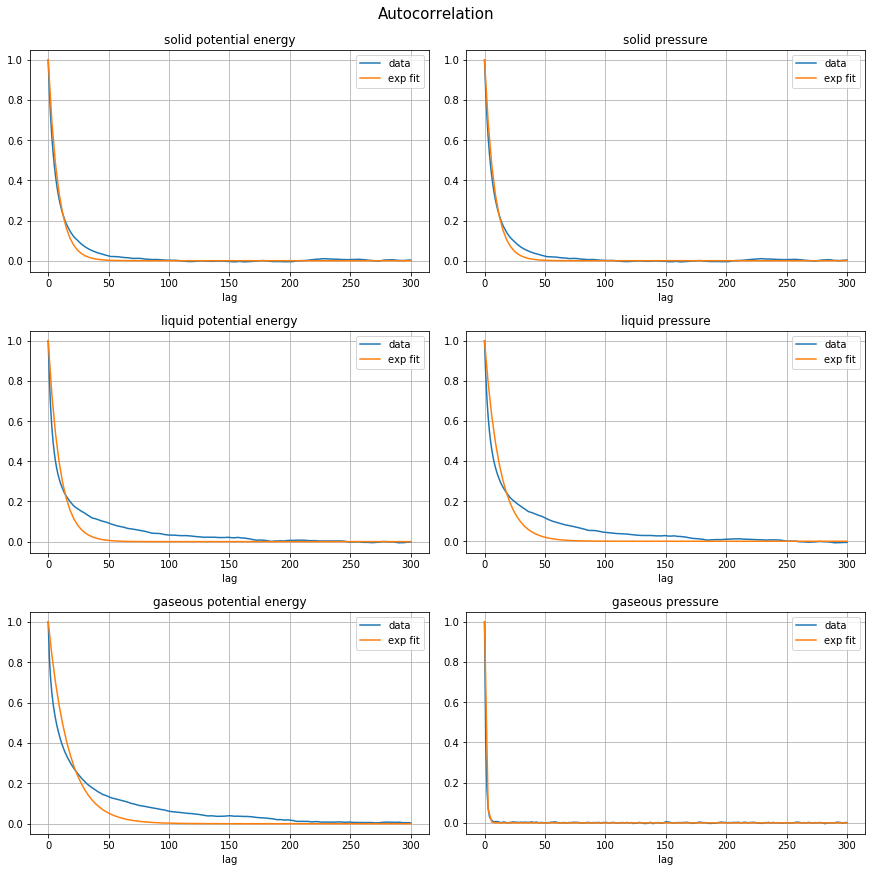

AUTOCORRELATION PROPER TIME
solid phase: tau_u = [8.25096443], tau_P = [8.10945894]
liquid phase: tau_u = [9.75654847], tau_P = [12.78246787]
gaseous phase: tau_u = [16.94789087], tau_P = [1.10359002]


In [2]:
phases = ['solid', 'liquid', 'gaseous']
fig, axs = plt.subplots(3,2, constrained_layout=True, figsize=(12,12))
fig.suptitle('Autocorrelation', fontsize=15)
maxlag = 300
exp_par = []

for index, phase in enumerate(phases):
    u, P = np.loadtxt('data/'+ phase +'_inst.dat', unpack=True)
    acorr_u = acf(u, nlags=maxlag, fft=True) #calculate autocorr
    acorr_P = acf(P, nlags=maxlag, fft=True)

    axs[index][0].plot(range(maxlag+1), acorr_u, label='data') #plot autocorrelation
    par_u, corr_u = scipy.optimize.curve_fit(lambda t,a: np.exp(-a*t),  range(maxlag+1),  acorr_u, p0=1) #fit autocorr
    x_pl = np.linspace(0,maxlag,100)
    axs[index][0].plot(x_pl, exp(-par_u*x_pl), label='exp fit')
    axs[index][0].set_title(phase +' potential energy')

    axs[index][1].plot(range(maxlag+1), acorr_P, label='data') #plot autocorrelation
    par_P, corr_P = scipy.optimize.curve_fit(lambda t,a: np.exp(-a*t),  range(maxlag+1),  acorr_P, p0=1) #fit autocorr
    x_pl = np.linspace(0,maxlag,100)
    axs[index][1].plot(x_pl, exp(-par_P*x_pl), label='exp fit')
    axs[index][1].set_title(phase +' pressure')
    
    exp_par.append([par_u, par_P]) # save fit parameters
    
for ax in axs.reshape(-1):
    ax.grid()
    ax.legend()
    ax.set_xlabel('lag')
    
plt.show()

print('AUTOCORRELATION PROPER TIME')
for (fit_u, fit_P), phase in zip(exp_par,phases):
    print('{0} phase: tau_u = {1}, tau_P = {2}'.format(phase, 1/fit_u, 1/fit_P))

La taglia dei blocchi consigliata sarebbe
- 16 per la fase solida
- 26 per la fase liquida
- 34 per la fase gassosa

### Studio dell'errore al variare della taglia dei blocchi

In [3]:
#returns uncertainty of "identity operator" dividing data  into blocks
def block_uncert(data, blocks): 
    if blocks <=0:
        print("block_ave cannot run, please assign a positive number of blocks")
        return 0
    m_sum = 0 
    m_sum2 = 0
    block_size = int(data.size/blocks)
    for i in range(blocks):
        block_ave = 0
        for j in range(block_size):
            k = j+i*block_size
            block_ave += data[k]
        block_ave /= block_size
        m_sum += block_ave
        m_sum2 += block_ave**2
    sigma = sqrt((m_sum2/blocks - (m_sum/blocks)**2)/(blocks-1))
    return sigma
        

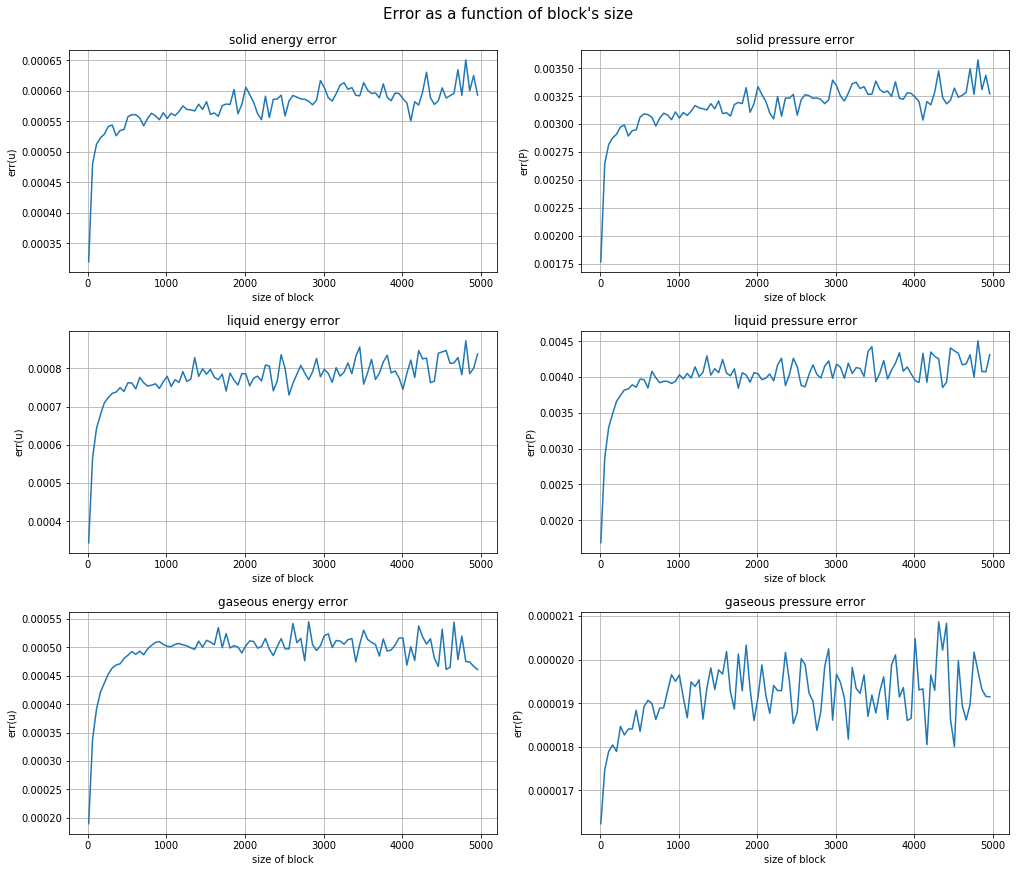

In [4]:
phases = ['solid', 'liquid', 'gaseous']
fig, axs = plt.subplots(3,2, constrained_layout=True, figsize=(14,12))
fig.suptitle('Error as a function of block\'s size', fontsize=15)

for index, phase in enumerate(phases):
    u,P = np.loadtxt('data/' + phase + '_inst.dat', unpack=True )
    array_of_sizes = np.arange(10, 5000, 50)
    array_of_nblocks = (u.size/array_of_sizes).astype(int)
    u_bl = []
    P_bl = []
    for i in array_of_nblocks:
        u_bl.append(block_uncert(u,i))
        P_bl.append(block_uncert(P,i))

    axs[index][0].plot(array_of_sizes, u_bl)
    axs[index][0].set_title(phase + ' energy error')
    axs[index][0].set_ylabel('err(u)')

    
    axs[index][1].plot(array_of_sizes, P_bl)
    axs[index][1].set_title(phase + ' pressure error')
    axs[index][1].set_ylabel('err(P)')

    
for ax in axs.reshape(-1):
    ax.grid()
    ax.set_xlabel('size of block')

plt.show()

###### Commento
In generale, l'errore satura intorno ai 500 elementi per blocco.

## Simulazione Argon

### Grandezze termodinamiche
Mostriamo gli andamenti di energia potenziale e pressione all'aumentare dei blocchi considerati. I blocchi sono da 500 misure ciascuno.

Il gas simulato è l'Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) nelle condizioni:
1. fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (r cut-off: $r_c = 2.2$)
2. fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (r cut-off: $r_c = 2.5$)
3. fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (r cut-off: $r_c = 5.0$)

In [5]:
def prog_ave(vec):
    ave = np.zeros(vec.size)
    err = np.zeros(vec.size)
    sum = 0
    sum2 = 0
    
    for i in range(vec.size):
        sum += vec[i]
        sum2 += vec[i]**2
        ave[i] = sum/(i+1)
        
        if i==0:
            err[i]=0
        else:
            err[i] = math.sqrt( (sum2/(i+1) - (sum/(i+1))**2)/i )
    
    return ave, err

def data_blocking(data, block_size):
    if block_size <=0:
        print("block_ave cannot run, please assign a positive number of blocks")
        return 0
    
    blocks = int(data.size/block_size)
    error = np.zeros(blocks)
    cumul_ave = np.zeros(blocks)
    block_ave = 0
    m_sum = 0
    m_sum2 = 0
    
    for i in range(blocks):
        block_sum = 0
        for j in range(block_size):
            block_sum += data[j+i*block_size]
        block_ave  = block_sum/block_size 
        m_sum += block_ave
        m_sum2 += block_ave**2
        cumul_ave[i] = m_sum/(i+1)
        if i==0:
            error[i]=0
        else:
            error[i] = math.sqrt( (m_sum2/(i+1) - (m_sum/(i+1))**2)/i )
    return cumul_ave, error

In [7]:
# SI units
sigma = 0.34*10**(-9)
k_b = 1.38065*10**(-23)
epsonk = 120;

dimensional_E = epsonk*k_b
dimensional_P = dimensional_E * sigma**(-3)

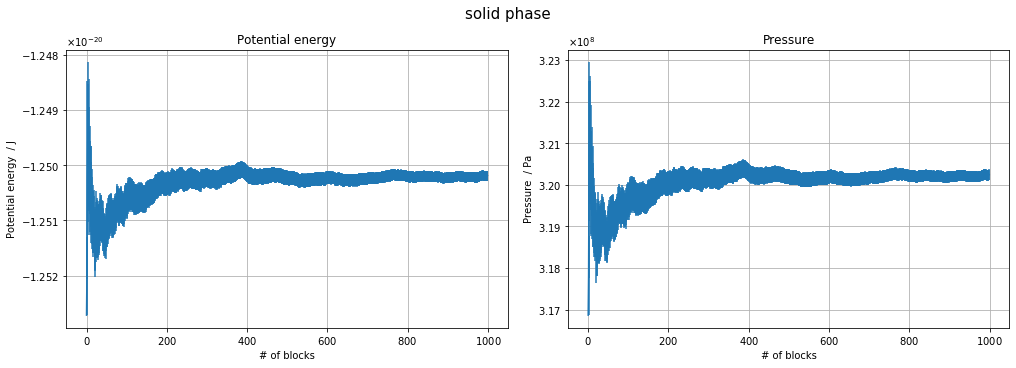

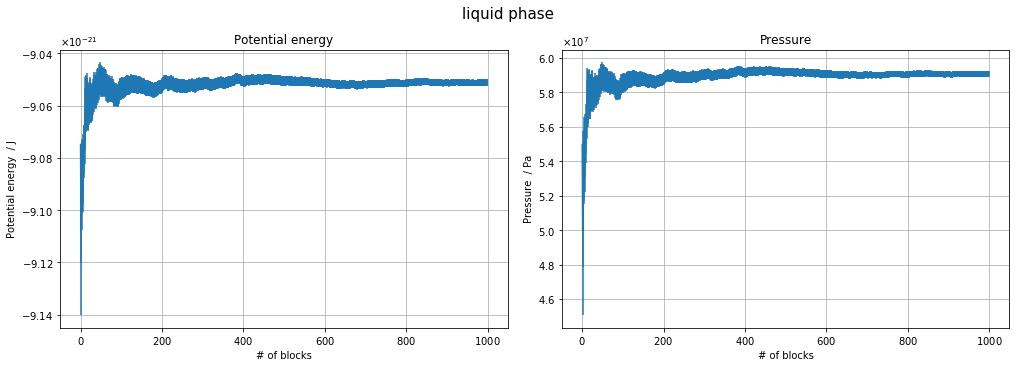

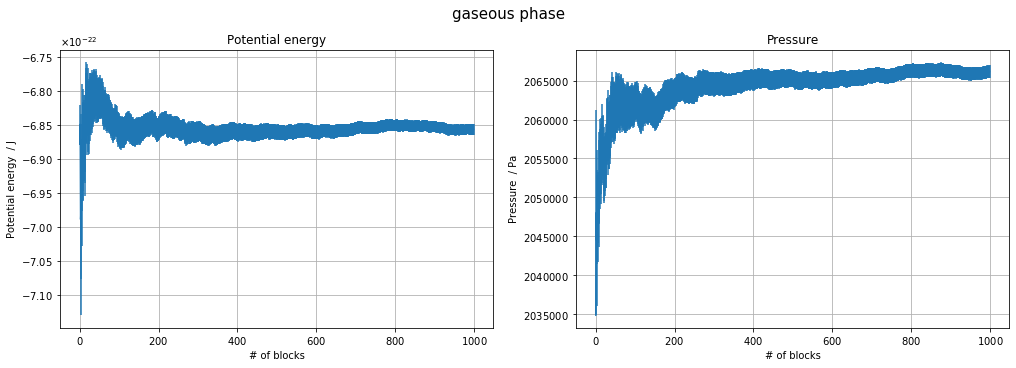

In [8]:
block_size=500
phases = ['solid', 'liquid', 'gaseous']
observables = ['Potential energy', 'Pressure']
unit_meas = ['J', 'Pa']

for phase in phases:
    fig, axs = plt.subplots(1,2, constrained_layout = True, figsize=(14,5))
    fig.suptitle(phase + ' phase', fontsize=15)
    data = np.loadtxt('data/' + phase + '_inst.dat')
    
    for i_ob, ob in enumerate(observables):
        value, err = data_blocking(data[:,i_ob], block_size)
        
        if(ob == 'Potential energy'): #set IS units
            value *= dimensional_E
            err *= dimensional_E
        if(ob == 'Pressure'):
            value *= dimensional_P
            err *= dimensional_P
            
        steps = np.arange(value.size)
        axs[i_ob].errorbar(steps, value, err)
        
        axs[i_ob].set_title(ob)
        axs[i_ob].set_xlabel('# of blocks')
        axs[i_ob].set_ylabel(ob + '  / ' + unit_meas[i_ob])
        axs[i_ob].grid()
        axs[i_ob].ticklabel_format(useMathText=True)

plt.show()

### Funzione di distribuzione radiale g(r)

Ora mostriamo la funzione di distribuzione radiale, calcolata con metodo MC e MD. 

#### Autocorrelazione in MD
Prima di effettuare le simulazioni, studio l'autocorrelazione nell'algoritmo di MD così da formare dei blocchi dellla giusta taglia.

[-0.300487 -0.29636  -0.291427 ... -0.350862 -0.349979 -0.348402]


/Users/edison/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


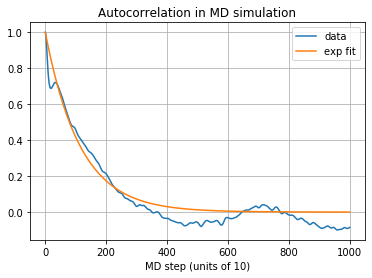

Proper time = 114.18594947203889


In [9]:
maxlag = 1000

u = np.loadtxt('data/MD_toacorr.dat', usecols=(0))
print (u)
acorr_u = acf(u, nlags=maxlag, fft=True) #calculate autocorr
plt.plot(range(maxlag+1), acorr_u, label='data') #plot autocorrelation
par_u, corr_u = scipy.optimize.curve_fit(lambda t,a: np.exp(-a*t),  range(maxlag+1),  acorr_u, p0=1) #fit autocorr
x_pl = np.linspace(0,maxlag,100)
plt.plot(x_pl, exp(-par_u*x_pl), label='exp fit')

plt.title('Autocorrelation in MD simulation')
plt.xlabel('MD step (units of 10)')
plt.grid()
plt.legend()
plt.show()

print('Proper time = {0}'.format( 1/par_u[0]))

Perciò utilizzeremo blocchi da 250 (x 10) step nel codice di MD. I blocchi sono molto grandi perchè l'evoluzione segue le equazioni del moto, pertanto gli step sono altamente correlati.

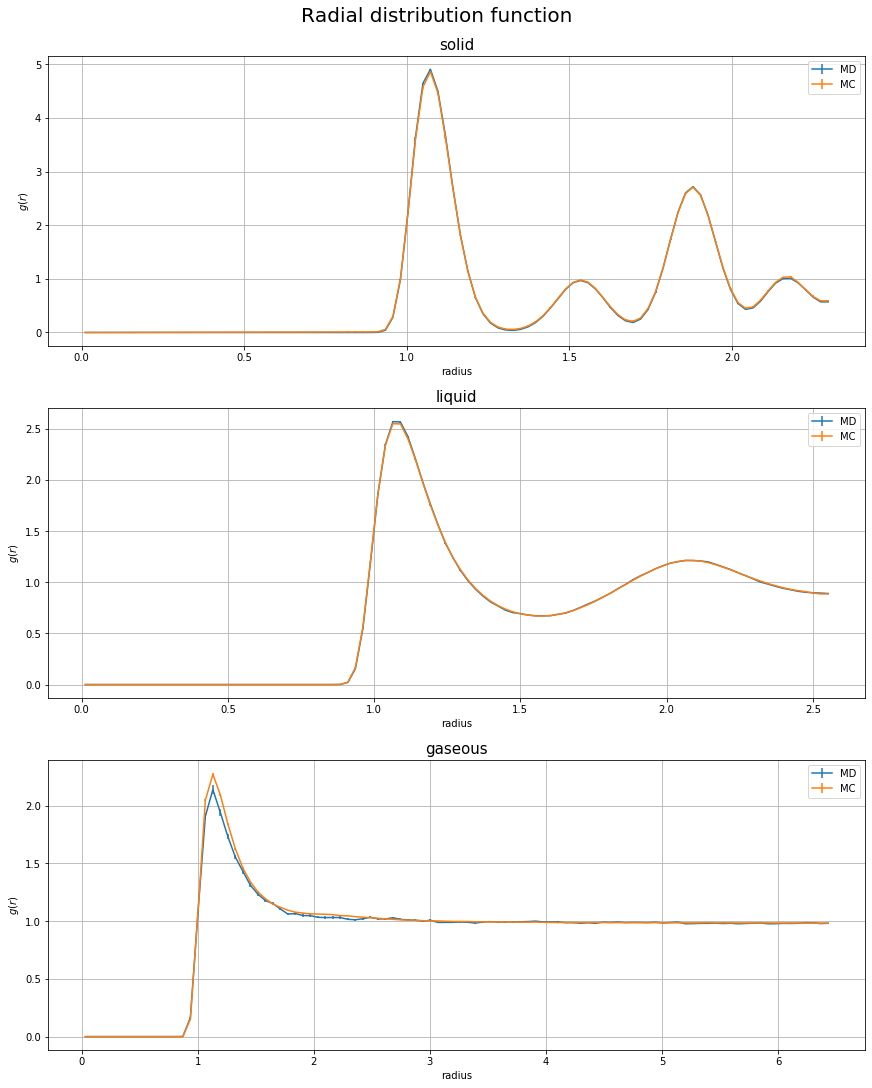

In [10]:
algorithms = ['MD', 'MC']

fig, axs = plt.subplots(3,1, figsize=(12,15), constrained_layout=True)
fig.suptitle('Radial distribution function', fontsize=20)

for i_phase, phase in enumerate(phases):
    ax = axs[i_phase]
    
    for alg in algorithms:
        file = 'data/gofr_' + phase + '_' + alg + '.dat'
        r = np.loadtxt(file, max_rows=1)
        g_r = np.loadtxt('data/gofr_' + phase + '_' + alg + '.dat', skiprows=1)
        n_blocks = g_r.shape[0]
        n_bins = len(r)
        g_ave = [ np.average(g_r[:,i])  for i in range(n_bins) ]
        g_err = [ sqrt(np.var(g_r[:,i])/(n_bins-1)) for i in range(n_bins) ]
        ax.errorbar(r,g_ave, g_err, label=alg)
       
    ax.set_title(phase, fontsize=15)
    ax.set_xlabel('radius')
    ax.set_ylabel('$g(r)$')
    ax.grid()
    ax.legend(loc='upper right')
    
plt.show()

Si nota un perfetto accordo tra i due metodi. È importante sottolineare che i due metodi lavorano in due ensemble diversi: MD in ensemble microcanonico e MC in ensemble canonico. Si può toccare con mano che nel limite termodinamico gli ensemble sono equivalenti. Le uniche differenze si apprezzano nel sistema gassoso, dove il picco della funzione $g(r)$ sembra risolto meno bene dalla tecnica di dinamica molecolare, si nota anche una barra di errore più grande del solito in corrispondenza di quel punto.